In [3]:
!pip install transformers


In [161]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
import matplotlib.pyplot as plt

In [162]:
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")



In [163]:
model.base_model.config

BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.5.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [164]:
pytorch_total_params = sum(p.numel() for p in model.base_model.parameters() if p.requires_grad)    
pytorch_trainable_params = sum(p.numel() for p in model.base_model.parameters() )    
print("Total number of params", pytorch_total_params)
print("Total number of trainable params", pytorch_trainable_params)

Total number of params 334092288
Total number of trainable params 334092288


In [165]:
text = r"""Japan is the eleventh-most populous country in the world, as well as one of the most densely populated and urbanized.
 About three-fourths of the country's terrain is mountainous, concentrating its population of 125.57 million on narrow coastal plains. 
 Japan is divided into 47 administrative prefectures and eight traditional regions.
 Osaka has a big population of 16 million. 
 The Greater Tokyo Area is the most populous metropolitan area in the world, with more than 37.4 million residents. 
"""

In [166]:
import numpy as np
def get_top_answers(possible_starts,possible_ends,input_ids):
  answers = []
  for start,end in zip(possible_starts,possible_ends):
    #+1 for end
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[start:end+1]))
    answers.append( answer )
  return answers  

def answer_question(question,context,topN):

    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")
    
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    model_out = model(**inputs)
     
    answer_start_scores = model_out["start_logits"]
    answer_end_scores = model_out["end_logits"]

    possible_starts = np.argsort(answer_start_scores.cpu().detach().numpy()).flatten()[::-1][:topN]
    possible_ends = np.argsort(answer_end_scores.cpu().detach().numpy()).flatten()[::-1][:topN]
    
    #get best answer
    answer_start = torch.argmax(answer_start_scores)  
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    answers = get_top_answers(possible_starts,possible_ends,input_ids )

    return { "answer":answer,"answer_start":answer_start,"answer_end":answer_end,"input_ids":input_ids,
            "answer_start_scores":answer_start_scores,"answer_end_scores":answer_end_scores,"inputs":inputs,"answers":answers,
            "possible_starts":possible_starts,"possible_ends":possible_ends}

In [167]:
questions = [
    "How many states in Japan?",
    "What is the population of Japan?",
    "Which city is most crowded in the world?",
    "What is the city with most population?",
    "What is the topic here?",
    "What are we talking about?",
    "What is the main idea here?"
]

In [168]:
questions = [    
    "Where is the most populous metropolitan area in the world ?",
    "Where is the most populous city ?",
    "What is the most populous city ?",
    "Where is most populous in the world ?",
    "Where is most populous?",
    "What is Population of Tokyo ?",
    "Which city is most crowded in the world ?",
    "Which city has biggest population ?",
    "Which city has most population ?",
    ]

questions3 = [
    "Most populous city ?"  ,    
    #"Most populous city?"  ,       
    "Most populous city"  
    
    ]

for q in questions:
  answer_map = answer_question(q,text,5)    
  print("Question:",q)
  print("Answers:")
  [print((index+1)," ) ",ans) for index,ans in  enumerate(answer_map["answers"]) if len(ans) > 0 ]
 
  

Question: Where is the most populous metropolitan area in the world ?
Answers:
1  )  greater tokyo area
2  )  the greater tokyo
3  )  tokyo area is the most populous metropolitan area in the world, with more than 37. 4 million residents.
4  )  japan is the eleventh - most populous country in the world, as well as one of the most densely populated and urbanized. about three - fourths of the country's terrain is mountainous, concentrating its population of 125. 57 million on narrow coastal plains. japan is divided into 47 administrative prefectures and eight traditional regions. osaka has a big population of 16 million. the greater tokyo area is the most populous metropolitan area in the world
5  )  japan is divided into 47 administrative prefectures and eight traditional regions. osaka has a big population of 16 million. the greater tokyo area is the most populous metropolitan area in the world,
Question: Where is the most populous city ?
Answers:
1  )  osaka
2  )  greater tokyo
4  )  j

In [169]:
answer_map = answer_question("Where is most populous in the world?",text,3)

In [170]:
print("input_ids:",answer_map["inputs"]["input_ids"] )
print("token_type_ids:",answer_map["inputs"]["token_type_ids"] )
print("attention_mask:",answer_map["inputs"]["attention_mask"] )
#answer_map["inputs"]

input_ids: tensor([[  101,  2073,  2003,  2087, 20151,  1999,  1996,  2088,  1029,   102,
          2900,  2003,  1996, 11911,  1011,  2087, 20151,  2406,  1999,  1996,
          2088,  1010,  2004,  2092,  2004,  2028,  1997,  1996,  2087, 19441,
         10357,  1998,  3923,  3550,  1012,  2055,  2093,  1011,  2959,  2015,
          1997,  1996,  2406,  1005,  1055,  9291,  2003, 14897,  1010, 16966,
          2049,  2313,  1997,  8732,  1012,  5401,  2454,  2006,  4867,  5780,
          8575,  1012,  2900,  2003,  4055,  2046,  4700,  3831,  7498,  2015,
          1998,  2809,  3151,  4655,  1012, 13000,  2038,  1037,  2502,  2313,
          1997,  2385,  2454,  1012,  1996,  3618,  5522,  2181,  2003,  1996,
          2087, 20151,  4956,  2181,  1999,  1996,  2088,  1010,  2007,  2062,
          2084,  4261,  1012,  1018,  2454,  3901,  1012,   102]])
token_type_ids: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1,

In [171]:
print( len(answer_map["input_ids"] ))
tokenizer.decode( answer_map["input_ids"] )  

108


"[CLS] where is most populous in the world? [SEP] japan is the eleventh - most populous country in the world, as well as one of the most densely populated and urbanized. about three - fourths of the country's terrain is mountainous, concentrating its population of 125. 57 million on narrow coastal plains. japan is divided into 47 administrative prefectures and eight traditional regions. osaka has a big population of 16 million. the greater tokyo area is the most populous metropolitan area in the world, with more than 37. 4 million residents. [SEP]"

In [172]:
def plot_possible_answer(start_scores,end_scores):
  fig,axes = plt.subplots(2,1)
  y_start = start_scores.detach().numpy().flatten()
  x_start = [i for i in range(len(y_start))]

  y_end = end_scores.detach().numpy().flatten()
  x_end = [i for i in range(len(y_end))]

  axes[0].bar(x_start,y_start)
  axes[0].set_title("start scores( "+ str( len( y_start ) ) +")" )
  axes[1].bar(x_end,y_end, color="orange")
  axes[1].set_title("end scores( "+ str( len( y_end ) ) +")" )
  fig.tight_layout()


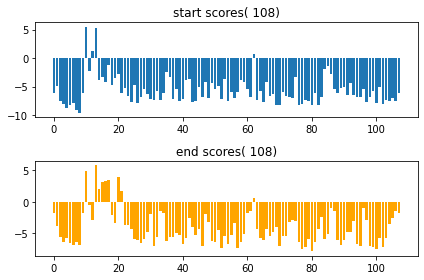

In [173]:
plot_possible_answer(answer_map["answer_start_scores"],answer_map["answer_end_scores"])